In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# load the dataset
df = pd.read_csv('D1.csv')

# correct data type for InvoiceNo and CustomerID
df['InvoiceNo'] = df['InvoiceNo'].astype(str)
df['CustomerID'] = df['CustomerID'].astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format = '%d/%m/%Y %H:%M', box = False)

#cleaning missing data
df = df.replace('nan', np.NaN)
df.isnull().sum()

mask = pd.isnull(df['Description'])
df = df[~mask]

df = df.drop(df[df['Quantity'] > 1000].index)
df = df.drop(df[df['Quantity'] == 0].index)

transactions = df.groupby(['InvoiceNo'])['Description'].apply(list)

print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19065 entries, 0 to 19662
Data columns (total 8 columns):
InvoiceNo      19065 non-null object
StockCode      19065 non-null object
Description    19065 non-null object
Quantity       19065 non-null int64
InvoiceDate    19065 non-null datetime64[ns]
UnitPrice      19065 non-null float64
CustomerID     15668 non-null object
Country        19065 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 1.3+ MB
None


In [2]:
print(transactions.head(5))

InvoiceNo
536365                 [WHITE HANGING HEART T-LIGHT HOLDER]
536367                      [ASSORTED COLOUR BIRD ORNAMENT]
536373                 [WHITE HANGING HEART T-LIGHT HOLDER]
536375                 [WHITE HANGING HEART T-LIGHT HOLDER]
536378    [JUMBO BAG PINK POLKADOT, LUNCH BAG RED RETROS...
Name: Description, dtype: object


In [3]:
#start association mining
from apyori import apriori

transaction_list = list(transactions)
results = list(apriori(transaction_list, min_support = 0.02))

print(results[:5])

[RelationRecord(items=frozenset({'ASSORTED COLOUR BIRD ORNAMENT'}), support=0.15195565781217318, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'ASSORTED COLOUR BIRD ORNAMENT'}), confidence=0.15195565781217318, lift=1.0)]), RelationRecord(items=frozenset({'HEART OF WICKER SMALL'}), support=0.12549675800041832, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'HEART OF WICKER SMALL'}), confidence=0.12549675800041832, lift=1.0)]), RelationRecord(items=frozenset({'JUMBO BAG PINK POLKADOT'}), support=0.1273792093704246, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'JUMBO BAG PINK POLKADOT'}), confidence=0.1273792093704246, lift=1.0)]), RelationRecord(items=frozenset({'JUMBO BAG RED RETROSPOT'}), support=0.21867810081572892, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'JUMBO BAG RED RETROSPOT'}), confidence=0.21867810081572892, lift=1.0)]), RelationR

In [4]:
def convert_apriori_results_to_pandas_df(results):
    rules = []
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base), ','.join(rule.items_add),
                rule_set.support, rule.confidence, rule.lift])
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support','Confidence', 'Lift'])
result_df = convert_apriori_results_to_pandas_df(results)
result_df = result_df.sort_values(by='Lift', ascending=False)

#setting min_confidence
confidence_filter = result_df[result_df['Confidence'] > 0.2 ]
#printing out top 5 interesting rules
print("==> RULES WITH HIGHEST LIFT VALUES")
print(confidence_filter.head(2))
print("\n==> RULES WITH LOWEST LIFT VALUES")
print(confidence_filter.tail(2))
print("\n==> RULES WITH HIGHEST CONFIDENCE VALUE")
confidence_filter = confidence_filter.sort_values(by='Confidence', ascending=False)
print(confidence_filter.head(2))

==> RULES WITH HIGHEST LIFT VALUES
                                           Left_side               Right_side  \
170  JUMBO BAG RED RETROSPOT,LUNCH BAG  BLACK SKULL.  LUNCH BAG RED RETROSPOT   
164  JUMBO BAG PINK POLKADOT,LUNCH BAG RED RETROSPOT  JUMBO BAG RED RETROSPOT   

      Support  Confidence      Lift  
170  0.024576    0.625000  3.821132  
164  0.026041    0.770898  3.525263  

==> RULES WITH LOWEST LIFT VALUES
                           Left_side                          Right_side  \
94           LUNCH BAG  BLACK SKULL.  WHITE HANGING HEART T-LIGHT HOLDER   
139  PACK OF 72 RETROSPOT CAKE CASES  WHITE HANGING HEART T-LIGHT HOLDER   

      Support  Confidence      Lift  
94   0.027505    0.206599  0.875275  
139  0.028132    0.204252  0.865334  

==> RULES WITH HIGHEST CONFIDENCE VALUE
                                           Left_side               Right_side  \
164  JUMBO BAG PINK POLKADOT,LUNCH BAG RED RETROSPOT  JUMBO BAG RED RETROSPOT   
43                        

In [5]:
JUMBO_BAG_PINK_POLKADOT = confidence_filter[confidence_filter['Left_side'] == 'JUMBO BAG PINK POLKADOT' ]
print(JUMBO_BAG_PINK_POLKADOT)

                   Left_side                                       Right_side  \
43   JUMBO BAG PINK POLKADOT                          JUMBO BAG RED RETROSPOT   
49   JUMBO BAG PINK POLKADOT                          LUNCH BAG RED RETROSPOT   
55   JUMBO BAG PINK POLKADOT               WHITE HANGING HEART T-LIGHT HOLDER   
46   JUMBO BAG PINK POLKADOT                          LUNCH BAG  BLACK SKULL.   
160  JUMBO BAG PINK POLKADOT  JUMBO BAG RED RETROSPOT,LUNCH BAG RED RETROSPOT   

      Support  Confidence      Lift  
43   0.086174    0.676519  3.093675  
49   0.033780    0.265189  1.621314  
55   0.026877    0.211002  0.893929  
46   0.026773    0.210181  1.578749  
160  0.026041    0.204433  3.376154  


<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 170 to 74
Data columns (total 5 columns):
Left_side     173 non-null object
Right_side    173 non-null object
Support       173 non-null float64
Confidence    173 non-null float64
Lift          173 non-null float64
dtypes: float64(3), object(2)
memory usage: 8.1+ KB
None
-------------


C:\Users\htdat\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


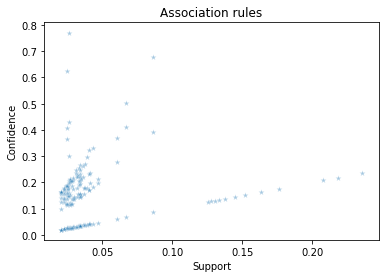

In [6]:
print(result_df.info())
print('-------------')
ax = sns.scatterplot(result_df['Support'], result_df['Confidence'], alpha=0.4, marker='*')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Association rules')
plt.show()

In [7]:
from collections import defaultdict
import subprocess
import re

''' Uses SPMF to find association rules in supplied transactions '''
def get_association_rules(sequences, min_sup, min_conf):
    # step 1: create required input for SPMF
    
    # prepare a dict to uniquely assign each item in the transactions to an int ID
    item_dict = defaultdict(int)
    output_dict = defaultdict(str)
    item_id = 1
    
    # write your sequences in SPMF format
    with open('seq_rule_input.txt', 'w+') as f:
        for sequence in sequences:
            z = []
            for itemset in sequence:
                # if there are multiple items in one itemset
                if isinstance(itemset, list):
                    for item in itemset:
                        if item not in item_dict:
                            item_dict[item] = item_id
                            item_id += 1

                        z.append(item_dict[item])
                else:
                    if itemset not in item_dict:
                        item_dict[itemset] = item_id
                        output_dict[str(item_id)] = itemset
                        item_id += 1
                    z.append(item_dict[itemset])
                    
                # end of itemset
                z.append(-1)
            
            # end of a sequence
            z.append(-2)
            f.write(' '.join([str(x) for x in z]))
            f.write('\n')
    
    # run SPMF with supplied parameters
    supp_param = '{}%'.format(int(min_sup * 100))
    conf_param = '{}%'.format(int(min_conf * 100))
    subprocess.call(['java', '-jar', 'spmf.jar', 'run', 'RuleGrowth', 
                     'seq_rule_input.txt', 'seq_rule_output.txt', 
                     supp_param, conf_param], shell=True)
    
    # read back the output rules
    outputs = open('seq_rule_output.txt', 'r').read().strip().split('\n')
    output_rules = []
    for rule in outputs:
        left, right, sup, conf = re.search(pattern=r'([0-9\,]+) ==> ([0-9\,]+) #SUP: ([0-9]+) #CONF: ([0-9\.]+)', string=rule).groups()
        sup = int(sup) / len(sequences)
        conf = float(conf)
        output_rules.append([[output_dict[x] for x in left.split(',')], [output_dict[x] for x in right.split(',')], sup, conf, conf/sup])
    
    # return pandas DataFrame
    return pd.DataFrame(output_rules, columns = ['Left_rule', 'Right_rule', 'Support', 'Confidence', 'Lift'])

In [8]:
#task 4
#group transaction by CustomerID and InvoiceNo
transactions = df.groupby(['CustomerID','InvoiceNo'])['Description'].apply(list)
print (transactions.head(10))

CustomerID  InvoiceNo
12347.0     542237                              [REGENCY CAKESTAND 3 TIER]
            549222                              [REGENCY CAKESTAND 3 TIER]
            562032                              [REGENCY CAKESTAND 3 TIER]
            573511                              [REGENCY CAKESTAND 3 TIER]
12349.0     577609       [SET OF 3 CAKE TINS PANTRY DESIGN , REGENCY CA...
12352.0     544156                              [REGENCY CAKESTAND 3 TIER]
            567505       [SET OF 3 CAKE TINS PANTRY DESIGN , REGENCY CA...
            568699                     [SET OF 3 CAKE TINS PANTRY DESIGN ]
12354.0     550911                               [LUNCH BAG RED RETROSPOT]
12355.0     552449                              [REGENCY CAKESTAND 3 TIER]
Name: Description, dtype: object


In [9]:
#transform into sequence
sequences = transactions.values.tolist()

# show the first 5 sequences
print(sequences[:20])

[['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER'], ['SET OF 3 CAKE TINS PANTRY DESIGN ', 'REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER'], ['SET OF 3 CAKE TINS PANTRY DESIGN ', 'REGENCY CAKESTAND 3 TIER'], ['SET OF 3 CAKE TINS PANTRY DESIGN '], ['LUNCH BAG RED RETROSPOT'], ['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER'], ['PACK OF 72 RETROSPOT CAKE CASES', 'REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER'], ['SET OF 3 CAKE TINS PANTRY DESIGN ', 'REGENCY CAKESTAND 3 TIER'], ['PARTY BUNTING'], ['REGENCY CAKESTAND 3 TIER'], ['REGENCY CAKESTAND 3 TIER', 'SET OF 3 CAKE TINS PANTRY DESIGN ', 'JUMBO BAG RED RETROSPOT', 'REGENCY CAKESTAND 3 TIER', 'REGENCY CAKESTAND 3 TIER'], ['LUNCH BAG RED RETROSPOT'], ['LUNCH BAG RED RETROSPOT']]


In [15]:
get_association_rules(sequences, 0.02, 0.1)

,Left_rule,Right_rule,Support,Confidence,Lift
0,[LUNCH BAG RED RETROSPOT],[JUMBO BAG RED RETROSPOT],0.023739,0.160714,6.770186
1,[JUMBO BAG RED RETROSPOT],[LUNCH BAG RED RETROSPOT],0.025229,0.137586,5.453408
2,[LUNCH BAG RED RETROSPOT],[LUNCH BAG BLACK SKULL.],0.034174,0.231366,6.770186
3,[LUNCH BAG BLACK SKULL.],[LUNCH BAG RED RETROSPOT],0.027867,0.230989,8.288973
4,[JUMBO BAG RED RETROSPOT],[JUMBO BAG PINK POLKADOT],0.029243,0.159475,5.453408
5,[JUMBO BAG PINK POLKADOT],[JUMBO BAG RED RETROSPOT],0.034862,0.349024,10.011481
